# Overview

The data science team investigates how to create a model to correctly identify bird species by audio recordings of their respective calls. For MVP analysis, only three bird species are considered in the data set. Three models are produced; these are a simple decision tree, an ensemble of a decision tree and a random forest, and finally a sequential neural network. The ensemble model performs the best with an accuracy of ~47%, but there exists much room for improvement. The key focus for next steps and model betterment is integrity of the training data set.

# Business Problem

The hobby: birding. Over 18 million Americans participate in the activity, trekking  out to the wilderness in order to hear, see, and identify any birds they may happen upon. One of the greatest barriers to entry in birding, however, is the generally high degree of orinthological knowledge required for species identification; there exist many handbooks with pictures and descriptions of calls to aid hobbyists, but finding the necessary information in a short amount of time is often burdensome and taxing- by the time a birder leafs through the handbook to find the right page of the suspected species, the bird has already flown off, never to be seen again. And the birder is left wondering which bird he or she actually happened upon.

The solution: BirdBible. It is a web app that allows users to record actual bird calls in real time and, with this recording, identifies the encountered species. The app relies upon a model, based on over 1,000 recordings of bird species' calls, that decomposes calls into salient audio characteristics that enable species classification.

# Data Understanding

Data is sourced from a free online repository called xeno-canto. The database houses hundreds of user-submitted bird call recordings. Recordings are web scraped with the following code:

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import time

cpages=list(range(0,10))
fpages=list(range(48,54))
bpages=list(range(0,10))

for page in cpages:
    
    r = requests.get("https://www.xeno-canto.org/explore?query=northern+cardinal&pg="+str(page))
    soup = BeautifulSoup(r.text, 'html.parser')

    index=0
    links=soup.select("a[href*=download]")
    for link in links:
        index=index+1
        ending=link['href']
        url='https://www.xeno-canto.org'+ending
        download=requests.get(url)
        name='cardinal'+str(page)+str(index) + '.wav'
        with open(name, 'wb') as f:
            f.write(download.content)
        time.sleep(0.5)

for page in fpages:

    r = requests.get("https://www.xeno-canto.org/explore?query=goldfinch&pg="+str(page))
    soup = BeautifulSoup(r.text, 'html.parser')

    index=0
    links=soup.select("a[href*=download]")
    for link in links:
        index=index+1
        ending=link['href']
        url='https://www.xeno-canto.org'+ending
        download=requests.get(url)
        name='finch'+str(page)+str(index) + '.wav'
        with open(name, 'wb') as f:
            f.write(download.content)
        time.sleep(0.5)

for page in bpages:

    r = requests.get("https://www.xeno-canto.org/explore?query=blue+jay&pg="+str(page))
    soup = BeautifulSoup(r.text, 'html.parser')

    index=0
    links=soup.select("a[href*=download]")
    for link in links:
        index=index+1
        ending=link['href']
        url='https://www.xeno-canto.org'+ending
        download=requests.get(url)
        name='bluejay'+str(page)+str(index) + '.wav'
        with open(name, 'wb') as f:
            f.write(download.content)
        time.sleep(0.5)

The data used considers only three species of birds: cardinals, blue jays, and gold finches. Data is extracted in .wav format. 1181 sample recordings are extracted.

# Data Preparation, Exploratory Data Analysis (EDA), and Feature Engineering

The first step in analysis is the manipulation of extracted audio files to make model creation possible. Audio files are decomposed into a handful of salient characteristics which form the basis of features for modeling. These features are described below:

## Energy Root Mean Square

The energy root mean square of the audio recordings is a general gauge of energy (or in this case, volume) output of each recording. The easiest way of seeing such information is by viewing the standard waveform of .wav files, plotting decibel output over time. For analysis purposes, this information is averaged over the length of each recording. Reasoning for including within the model is that different bird species have different capacities for volume output, and therefore, average decibel output of a given call may lend aid in identifying a species by call recording.

The obvious drawback in using this property as a feature, though, is that the average decibel output relies heavily on integrity of the recording itself. Ambient noises and proximity to the bird in question are confounding factors that will influence each recording's overall average energy output.

Text(0.5, 0, 'Time (Seconds)')

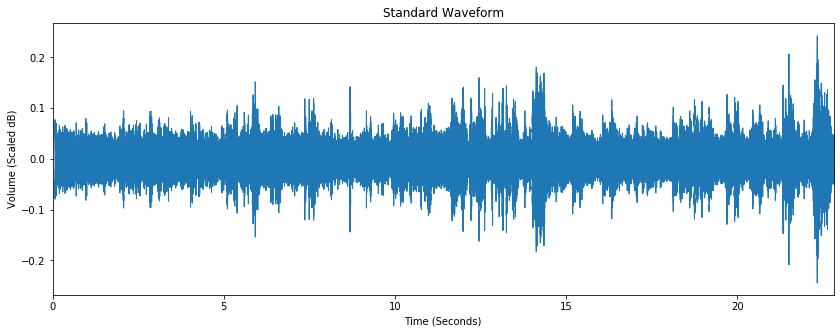

In [89]:
audiofile='./BlueJayCalls/BlueJayWAV/bluejay1.wav'
x , sr = librosa.load(audiofile)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Standard Waveform')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

The above is an example of a standard recording's waveform, wherein the energy output over time can be observed. As mentioned, obvious shortcoming of this feature is that the energy output is influenced by anything heard in the recording, not just the bird's call itself. For instance, the actual bird call in the pictured recording begins at about five seconds in (the first five seconds are white noise). This white noise can therefore affect the average energy root mean square value of the entire recording.

## Chroma Vector

Related to the overall energy output of a recording, the chroma vector categorizes a recording's energy output by pitch. In other words, it classifies over time how much of a recording's wave amplitude can be attributed to a given tone. As bird calls often follow the same tonal interval pattern, the chroma vector for specific bird calls becomes an invaluable gauge to differentiate one call from another.

Text(0.5, 1.0, 'Blue Jay Chroma Vector')

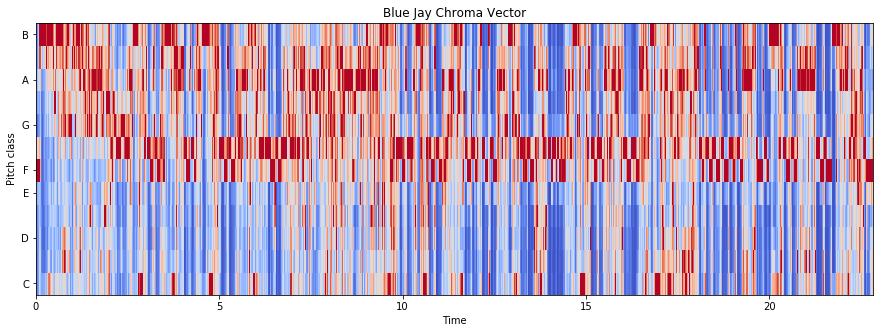

In [91]:
chromagram = librosa.feature.chroma_stft(x, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title('Blue Jay Chroma Vector')

As can be seen above, the blue jay's chroma vector indicates high presence of F and F# notes (on a conventional musical scale). The downside of this feature is that, with variation in individual birds' voiceboxes, pitch variation is also observed. However, enough pitch similarity exists within a species such that this gauge is still valuable in model construction.


## Spectral Centroid

Another gauge of pitch essentially, the spectral centroid of a recording finds the average frequency of a recording at a given point in time. However, this average frequency is weighted according to volume output. Altogether then, this gauge essentially calculates a sort of center of mass, in terms of frequency, for the bird calls. When averaged over the length of the recording, this gauge allows the model to compare the general frequency range at which each recording resides.

Text(0.5, 0, 'Time (Seconds)')

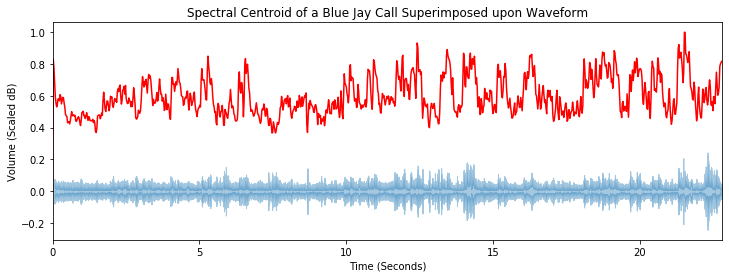

In [98]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]

plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.title('Spectral Centroid of a Blue Jay Call Superimposed upon Waveform')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

## Spectral Bandwidth

Spectral bandwidth measures, for a given point in a recording's time, the range of frequencies that are above a certain standard deviation threshhold of energy output. In other words, this essentially gauges a bird's instantaneous vocal range within a call and can help qualify the bird's tonal quality or character.

Seen below is the blue jay's spectral bandwidth superimposed upon a given call's standard waveform. Three different threshold standard deviations are displayed.

Text(0.5, 0, 'Time (Seconds)')

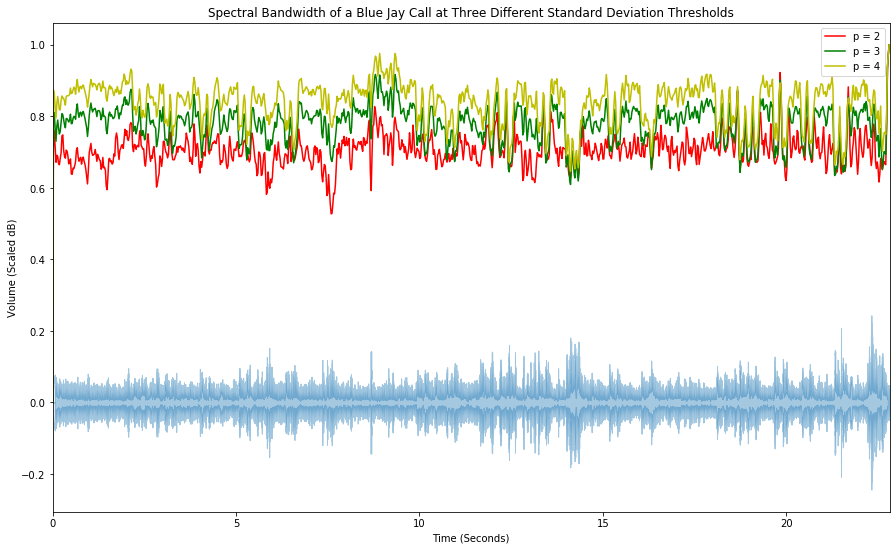

In [97]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))
plt.title('Spectral Bandwidth of a Blue Jay Call at Three Different Standard Deviation Thresholds')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

## Spectral Rolloff

Spectral rolloff is related to bandwidth. However, as opposed to indexing the magnitude of the frequency range within which a recording exists, it records the upper bound of that range. In this way, this feature generally measures how high the bird's call is. The spectral rolloff for a blue jay call can be seen below.

Text(0.5, 0, 'Time (Seconds)')

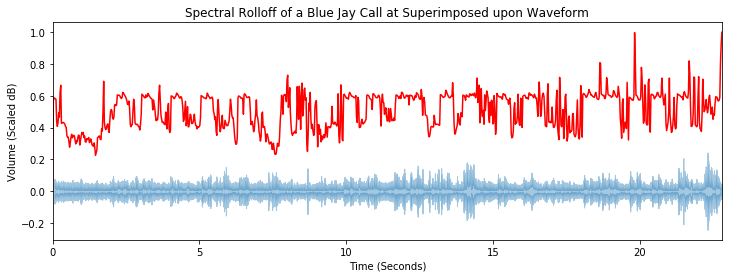

In [101]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.title('Spectral Rolloff of a Blue Jay Call at Superimposed upon Waveform')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

## Zero Crossing Rate

Zero crossing rate is another gauge to help analyze the tonal quality of a given bird's voice, specifically smoothness. In short, it measures the rate at which a recording's waveform oscillates from positive to negative decibel values. Below is a zoomed in version of the blue jay call's standard waveform, wherein these zero crossings are more easily seen.

Text(0.5, 0, 'Time (Seconds)')

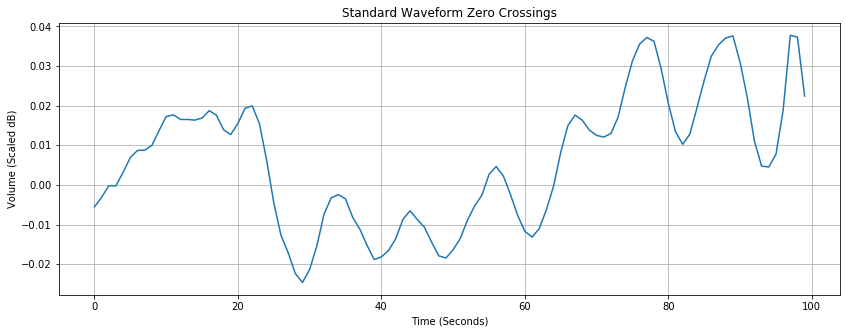

In [104]:
n0 = 8000
n1 = 8100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

plt.title('Standard Waveform Zero Crossings')
plt.ylabel('Volume (Scaled dB)')
plt.xlabel('Time (Seconds)')

All extracted audio samples are decomposed into the above six features. Features are averaged over the recording time.

In [119]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import librosa
import pyaudio
import numpy as np
import wave
import scipy.io.wavfile as wavfile
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
try:
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [ ]:
rmss=[]
chroma_stfts=[]
spec_cents=[]
spec_bws=[]
rolloffs=[]
zcrs=[]
species=[]
load_bar=0

for finchclip in finchclips:
    load_bar+=1
    if finchclip=='.ipynb_checkpoints':
        continue
    filename='./FinchCalls/FinchWAV/'+finchclip
    y, sr = librosa.load(filename, mono=True)#, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    rmss.append(np.mean(rmse))
    chroma_stfts.append(np.mean(chroma_stft))
    spec_cents.append(np.mean(spec_cent))
    spec_bws.append(np.mean(spec_bw))
    rolloffs.append(np.mean(rolloff))
    zcrs.append(np.mean(zcr))
    species.append('Finch')
    print(str(load_bar)+' of '+str(len(finchclips)))

In [ ]:
load_bar=0

for cardinalclip in cardinalclips:
    load_bar+=1
    if cardinalclip=='.ipynb_checkpoints':
        continue
    filename='./CardinalCalls/CardinalWAV/'+cardinalclip
    y, sr = librosa.load(filename, mono=True)#, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    rmss.append(np.mean(rmse))
    chroma_stfts.append(np.mean(chroma_stft))
    spec_cents.append(np.mean(spec_cent))
    spec_bws.append(np.mean(spec_bw))
    rolloffs.append(np.mean(rolloff))
    zcrs.append(np.mean(zcr))
    species.append('Cardinal')
    print(str(load_bar)+' of '+str(len(cardinalclips)))

In [ ]:
load_bar=0

for bluejayclip in bluejayclips:
    load_bar+=1
    if bluejayclip=='.ipynb_checkpoints':
        continue
    filename='./BlueJayCalls/BlueJayWAV/'+bluejayclip
    y, sr = librosa.load(filename, mono=True)#, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    rmss.append(np.mean(rmse))
    chroma_stfts.append(np.mean(chroma_stft))
    spec_cents.append(np.mean(spec_cent))
    spec_bws.append(np.mean(spec_bw))
    rolloffs.append(np.mean(rolloff))
    zcrs.append(np.mean(zcr))
    species.append('BlueJay')
    print(str(load_bar)+' of '+str(len(bluejayclips)))

In [ ]:
d = {'rmse': rmss, 
    'chroma': chroma_stfts, 
    'spectral_centroid': spec_cents, 
    'spectral_bandwidth': spec_bws,
    'rolloffs': rolloffs,
    'zero_crossing_rate': zcrs,
    'species':species}

df = pd.DataFrame(data=d)

Text(0.5, 1.0, 'Standard Deviations of Spectral Centroids')

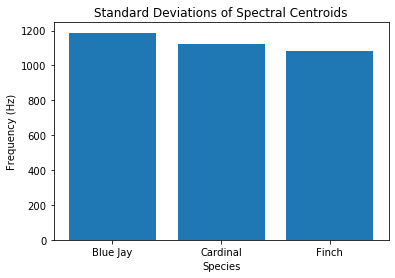

In [134]:
stds=df.groupby(by=['species']).std()
y=list(stds.spectral_centroid)
plt.bar(['Blue Jay', 'Cardinal', 'Finch'], y)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Species')
plt.title('Standard Deviations of Spectral Centroids')

Text(0.5, 1.0, 'Standard Deviations of Rolloffs')

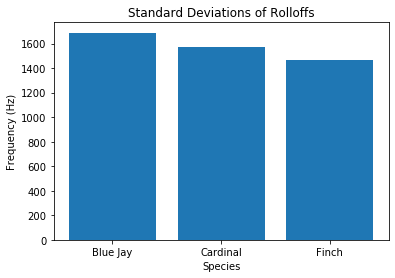

In [135]:
stds=df.groupby(by=['species']).std()
y=list(stds.rolloffs)
plt.bar(['Blue Jay', 'Cardinal', 'Finch'], y)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Species')
plt.title('Standard Deviations of Rolloffs')

In [133]:
df.groupby(by=['species']).std()

,rmse,chroma,spectral_centroid,spectral_bandwidth,rolloffs,zero_crossing_rate
species,,,,,,
BlueJay,0.025849,0.107857,1188.081868,378.035998,1688.287974,0.129551
Cardinal,0.026043,0.101492,1122.062078,388.233724,1574.327289,0.123872
Finch,0.027228,0.098117,1082.697905,374.294547,1467.236423,0.121857


# Model Fitting and Interpretation

## Train Test Split

In [109]:
# Establish features and target in data

features=df.drop(['species'], axis=1)
target=df.species

encoder = LabelEncoder()
y = encoder.fit_transform(target)

#encoder= LabelEncoder()
#y=encoder.fit_transform(z)

# Split features and target into training and testing partitions

X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=1)

# Scale feature set according to standard distribution to make results more interpretable
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

## Decision Tree Model

In [ ]:
param_grid = {
    'max_depth': list(range(1,20)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'min_weight_fraction_leaf': [0, 0.25, 0.5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.4, 0.8],
    'min_impurity_split': [0, 0.4, 0.8]
    }

# Grid search is executed with F1 as scoring method

grid_dt=GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=1), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_dt.fit(X_train, y_train)

grid_dt.best_params_

In [110]:
dtc = DecisionTreeClassifier(criterion= 'gini', 
                             max_depth=9, 
                             max_features='auto', 
                             min_impurity_decrease=0, 
                             min_impurity_split=0, 
                             min_samples_leaf=2, 
                             min_samples_split=2, 
                             min_weight_fraction_leaf=0, 
                             class_weight='balanced', 
                             random_state=1)

dtc.fit(X_train, y_train)

dtc_preds  = dtc.predict(X_test)

dtc_acc = metrics.accuracy_score(y_test, dtc_preds)

dtc_acc

0.44594594594594594

Image and text representation of this decision tree can be seen below.

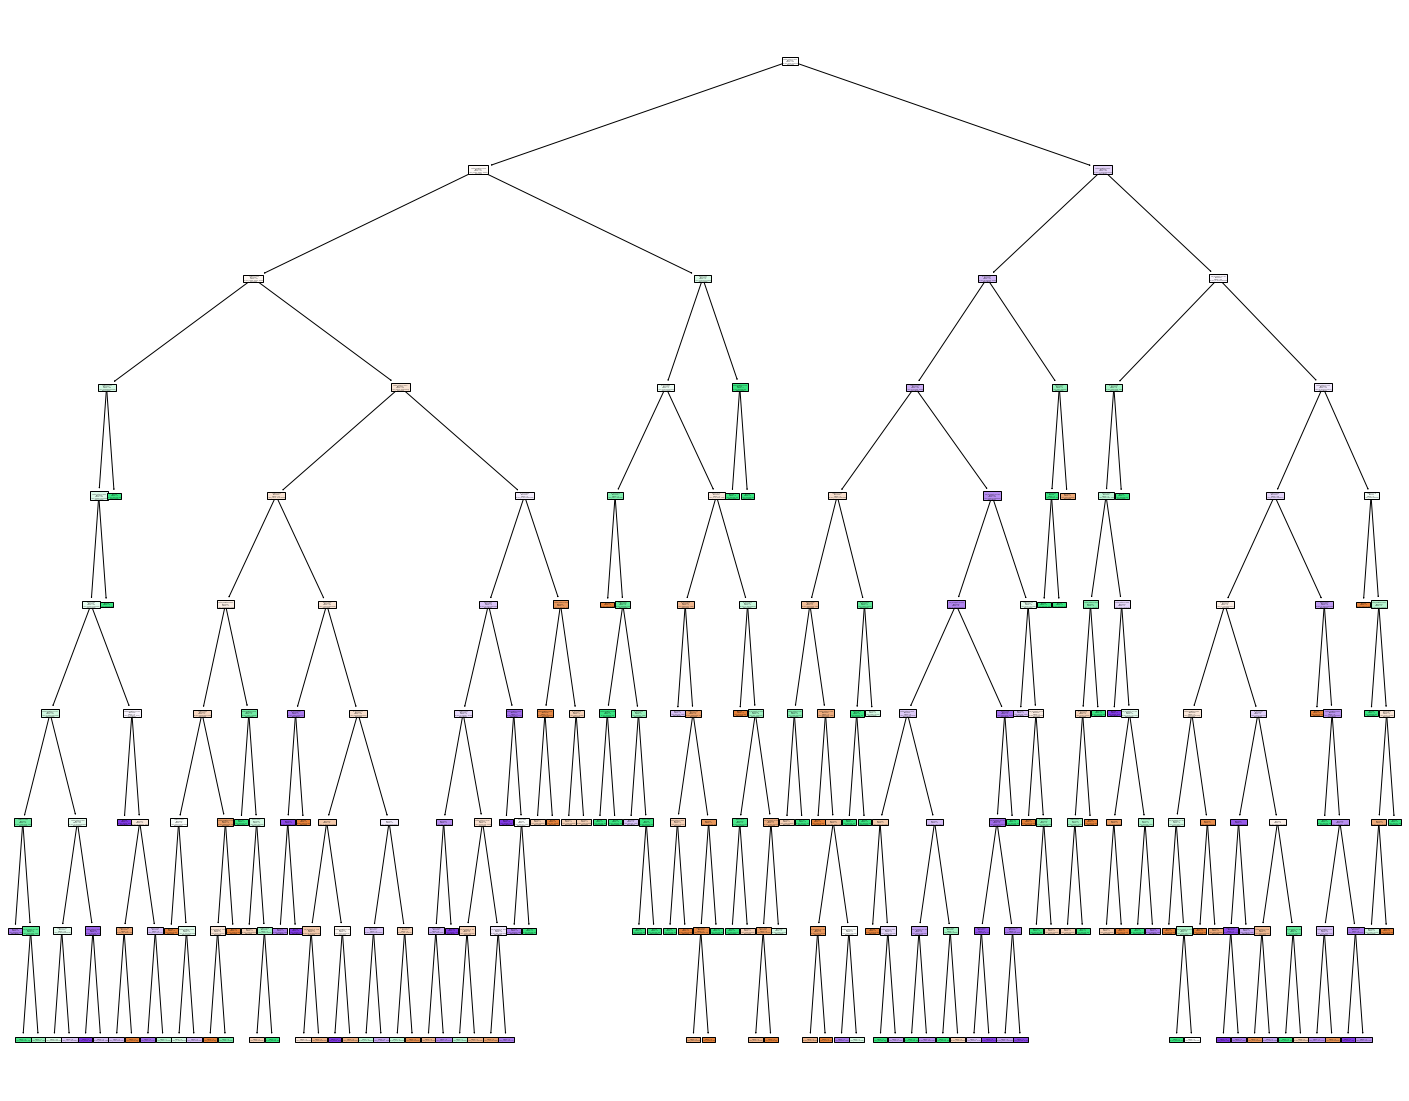

In [121]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, 
                   feature_names=features.columns,
                   class_names=['Finch', 'Cardinal', 'BlueJay'],
                   filled=True)
plt.savefig('decisiontree')

In [123]:
text_representation = tree.export_text(dtc)
print(text_representation)

|--- feature_2 <= 0.41
|   |--- feature_3 <= 0.99
|   |   |--- feature_1 <= -0.07
|   |   |   |--- feature_1 <= -0.13
|   |   |   |   |--- feature_2 <= 0.35
|   |   |   |   |   |--- feature_0 <= 1.03
|   |   |   |   |   |   |--- feature_3 <= -1.12
|   |   |   |   |   |   |   |--- feature_1 <= -2.00
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- feature_1 >  -2.00
|   |   |   |   |   |   |   |   |--- feature_5 <= 0.43
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_5 >  0.43
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_3 >  -1.12
|   |   |   |   |   |   |   |--- feature_2 <= 0.34
|   |   |   |   |   |   |   |   |--- feature_1 <= -0.31
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_1 >  -0.31
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- feature_2 >  0.34
|   |   |   |   |   |   |   | 

## Random Forest Decision Tree Ensemble Model

In [ ]:
# Random forest parameters are set up to be evaluated

param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1,20)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'min_weight_fraction_leaf': [0, 0.25, 0.5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.4, 0.8],
    'min_impurity_split': [0, 0.4, 0.8],
    'bootstrap': [True, False]
    }

# Grid search is executed with F1 as scoring method

grid_tree=GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Decision tree model is fit to data set and optimal parameters are found

grid_tree.fit(X_train, y_train)
grid_tree.best_params_

In [ ]:
# Establish random forest model

rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                              criterion='gini', max_depth=13,
                                              max_features='auto',
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=0.4,
                                              min_samples_leaf=2,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0,
                                              random_state=1)

# Fit random forest model to training data

rfc.fit(X_train, y_train)

# Make predictions on test set with model

rfc_preds  = rfc.predict(X_test)

# Evaluate decision tree model based on F1-score and precision, and display accuracy just for reference
rfc_acc = metrics.accuracy_score(y_test, rfc_preds)

# Create ensemble models for each combination of the accepted three models

vc1 = VotingClassifier(
                estimators=[('decisiontree', dtc), ('randomforest', rfc)], 
                voting='soft')

vc2 = VotingClassifier(
                estimators=[('decisiontree', dtc), ('randomforest', rfc)], 
                voting='hard')

# Fit each model to the training data

vc1.fit(X_train, y_train)
vc2.fit(X_train, y_train)


# Create bankruptcy predictions with each model

vc1_preds = vc1.predict(X_test)
vc2_preds = vc2.predict(X_test)

# Evaluate each model based on F1-score, and display accuracy just for reference

vc_acc_1 = metrics.accuracy_score(y_test, vc1_preds)

vc_acc_2 = metrics.accuracy_score(y_test, vc2_preds)

print(vc_acc_1, vc_acc_2)

## Sequential Neural Network

In [ ]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
sequential_nn = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=256)

In [ ]:
nn_preds = model.predict_classes(X_test)
nn_acc = metrics.accuracy_score(y_test, nn_preds)
nn_acc

# Conclusion and Next Steps

Overall the team finds that the ensemble model of the decision tree and random forest performs best, with an accuracy of 0.47. However, this indicative of relatively poor performance, seeing as the percent share of the majority class species is around 0.49.

The reason for poor performance is surmised to be overall integrity of sample recordings. Standard devaitions of rolloffs and spectral centroids differed by around 15% and 10% between species, respectively. As these birds are all similarly sized, these differences should not be as high.

To eliminate these differences, the team needs to cull the sampled recordings to a fewer amount of more representative audio files. Ideally, these recordings should limit extra white noise and should contain purely the target bird's call.